In [1]:
import numpy as np
import pandas as pd
import random
import operator
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

In [2]:
#load data
df = pd.read_csv('../data/breast-cancer-wisconsin.data.txt')

#clean data
df = df.replace('?',-99999)
df = df.astype(float)
df = df.drop(['id'],1)

#shuffle data
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True)

#copy data
tf = df.copy()

In [3]:
# Scale data
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(tf.iloc[:,:9])

y = tf.iloc[:,9].astype('int')

X, y = pd.DataFrame(X), pd.Series(y)

In [4]:
class PrincipalComponentAnalysis(object):
    
    def __init__(self, printing=False, k=2):
        self.printing = printing
        self.k = k
        
    def fit(self,X_train):
        self.trainSet = X_train #class is ignored
        self.n_features = X_train.shape[1]
        
        trainSet = self.trainSet
        
        #get feature means
        _means = trainSet.describe().loc['mean'].values 
        
        #create covariance matrix
        cov_mat = self.covariance_matrix(trainSet.T)
        
        #compute eigenvectors and eigenvalues from covariance matrix
        eig_pairs = self.eigen(cov_mat)
        
        ##create transformation matrix
        self.transformation_matrix(eig_pairs)
        
        return
    
    def covariance_matrix(self, dataset):
        """Computes the covariance matrix of a dataset"""
        cov_mat = np.cov(dataset)
        self.cov_mat = cov_mat
        return cov_mat
    
    def eigen(self, cov_mat):
        """Returns a sorted list of eigenvector/-value pairs"""
        # eigenvectors and eigenvalues for the from the covariance matrix
        eig_val, eig_vec = np.linalg.eig(cov_mat)
        
        #sorts eigenvalues to find corresponding eigenvectors -- strongest principal components
        top_eig_vals = np.sort(eig_val)
        self.top_eig_vals = top_eig_vals[::-1]
        
        #create pairs of eig_vals and eig_vecs
        eig_pairs = {}
        
        for i, val in enumerate(eig_val):
            eig_pairs[val] = eig_vec[i]
        
        self.eig_pairs = eig_pairs
        
        return eig_pairs
    
    def transformation_matrix(self, eig_pairs):
        """Uses k top eigenvectors as a transformation matrix"""
        k = self.k
        printing = self.printing
        
        #choose k eigenvectors with the largest eigenvalues
        top_eig_vals = self.top_eig_vals[0:k]
        
        #retrieve eigenvectors for the top k eigenvalues
        top_eig_vecs = []
        
        for val in top_eig_vals:
            eigvec = eig_pairs[val]
            top_eig_vecs.append(eigvec)
            
        #create transformation matrix from eigenvectors
        W = np.hstack(top_eig_vecs)
        W = W.reshape(k,self.n_features)
        self.W = W
        
        #printing options
        if printing:            
            print('Matrix W:\n', W)
            
        return W
    
    #project to k feature dimensions (i.e. k principle components)
    def transform(self, dataset):
        """Transform dataset"""
        printing = self.printing
        W = self.W
        
        pca_matrix = W.dot(dataset.T)
        
        if printing:
            print(pca_matrix)
        
        self.pca_matrix = pca_matrix
        
        return pca_matrix

### Train Model

In [5]:
PCA = PrincipalComponentAnalysis()
PCA.fit(X)
pca = PCA.transform(X)

### Plot Projection

In [6]:
#return PCA matrix
pca = pd.DataFrame(pca).T
pca = pd.concat([pca, pd.Series(list(y.index))],axis=1)
pca.columns = ['PC1','PC2','index']
pca = pca.set_index('index')

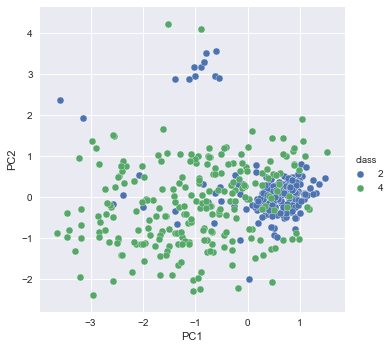

In [7]:
#add class to PCA matrix for plotting
cls_vals = y.astype('int')
df = pd.concat([pca, cls_vals], axis=1)
df.columns = ['PC1','PC2','class']

#plot PCA matrix
sns.pairplot(x_vars=["PC1"], y_vars=["PC2"], data=df, 
hue="class", size=5)